# **Many-to-Many GRU**

In [ ]:
!pip install muspy

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import muspy
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn_utils

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 2), "GB")
    print("Memory Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 2), "GB")

Using device: cuda
GPU Name: NVIDIA L4
Memory Allocated: 0.0 GB
Memory Cached: 0.0 GB


In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Now that we've prepared the imports and devices, let's load the metadata:

In [ ]:
metadata = pd.read_csv("/content/drive/MyDrive/Piano generation/Project/MAESTRO dataset/maestro-v3.0.0.csv")

Here, we use a different dataset. The diffence between this dataset and the one, used for the many-to-ont architecture is in `__getitem__`. It still returns a tuple of `(sequence, target)`, but this time target is a tensor of the latter half of `sequence` and the next `seq_len // 2`  time steps.

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, metadata, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.songs = []

        for file in metadata["midi_filename"]:
            file_path = os.path.join("/content/drive/MyDrive/Piano generation/Project/MAESTRO dataset/maestro-v3.0.0-midi/maestro-v3.0.0/", file)
            muspy_file = muspy.read(file_path)
            self.songs.append(muspy_file)

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        pianoroll_song = self.songs[idx].to_pianoroll_representation()
        pianoroll_song = torch.tensor(pianoroll_song, dtype=torch.float32)

        start_idx = random.randint(0, len(pianoroll_song) - 2 * self.seq_len)

        input_seq = pianoroll_song[start_idx:start_idx+self.seq_len]

        target = pianoroll_song[start_idx+(self.seq_len // 2) : start_idx+self.seq_len+(self.seq_len // 2)]

        return input_seq, target

Again, loading the datasets from a file is significantly faster:

In [ ]:
music_dataset_train = torch.load("/content/drive/MyDrive/Piano generation/Project/saved_data/datasets/train/music_dataset_train_many_to_many_muspy.pt", weights_only=False)
music_dataset_val = torch.load("/content/drive/MyDrive/Piano generation/Project/saved_data/datasets/validation/music_dataset_val_many_to_many_muspy.pt", weights_only=False)

The model is almost the same as its Many-to-one counterpart with the difference, that it now returns a tensor of `(seq_len, 128)` instead of a 128-dimensional vector.

In [ ]:
class ManyToManyGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(ManyToManyGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.ff = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.ff(out)

        return out

This is our collate function, in order to compensate for the difference in lengths:

In [ ]:
def collate_fn(batch):
    sequences, targets = zip(*batch)

    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)

    return sequences_padded, targets_padded

In [ ]:
music_dataloader_train = DataLoader(music_dataset_train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, collate_fn=collate_fn)
music_dataloader_val = DataLoader(music_dataset_val, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, collate_fn=collate_fn)

The model's setup is identical to the Many-to-one version. 128 is the input size, 256 is the hidden size, there are 2 GRU layers and the output size is 128.

In [ ]:
many_to_many_gru = ManyToManyGRU(128, 256, 128, 2).to(device)

optimizer = optim.AdamW(many_to_many_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

The train function is essentially the same as in the Many-to-One situation.

In [ ]:
def train_many_to_many_gru(model, optimizer, criterion, num_epochs, train_loss_history, val_loss_history, create_plot=True):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0

        for sequences, targets in tqdm(music_dataloader_train, f"Epoch {len(train_loss_history)}:"):
            sequences, targets = sequences.to(device), targets.to(device)

            optimizer.zero_grad()
            output = model(sequences)

            loss = criterion(output, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(music_dataloader_train)
        train_loss_history.append(avg_train_loss)
        print("Average Training Loss:", avg_train_loss)

        model.eval()
        val_loss = 0.0

        for sequences, targets in music_dataloader_val:
            sequences, targets = sequences.to(device), targets.to(device)

            with torch.no_grad():
                output = model(sequences)
                loss = criterion(output, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(music_dataloader_val)
        val_loss_history.append(avg_val_loss)
        print("Average Validation Loss:", avg_val_loss)
        model.train()

    if create_plot:
        plt.plot(train_loss_history, label="Training loss")
        plt.plot(val_loss_history, label="Validation loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()
        plt.show()
        plt.savefig(f"/content/drive/MyDrive/Piano generation/Project/saved_data/plots/many_to_many_gru_loss_epoch_{len(train_loss_history)}_plot.png")

    return train_loss_history, val_loss_history

Let's train the model for 20 epochs to see how the loss would behave:

<ipython-input-12-9499673c2641>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Training Loss: 61.291198115194995


Average Validation Loss: 66.85419235229492


Epoch 1:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Training Loss: 55.947194314772084


Average Validation Loss: 50.77190399169922


Epoch 2:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Training Loss: 53.09931090570265


Average Validation Loss: 50.82538757324219


Epoch 3:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Training Loss: 50.21660650930097


Average Validation Loss: 59.69589767456055


Epoch 4:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Training Loss: 52.368436628772365


Average Validation Loss: 58.631612396240236


Epoch 5:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Training Loss: 48.21047490642917


Average Validation Loss: 51.60841827392578


Epoch 6:: 100%|██████████| 31/31 [00:57<00:00,  1.84s/it]

Average Training Loss: 48.99212867982926


Average Validation Loss: 57.592186737060544


Epoch 7:: 100%|██████████| 31/31 [00:57<00:00,  1.87s/it]


Average Training Loss: 50.911216735839844
Average Validation Loss: 58.442832946777344


Epoch 8:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Training Loss: 49.61373015372984


Average Validation Loss: 48.33575553894043


Epoch 9:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 46.2339970988612


Average Validation Loss: 48.955072021484376


Epoch 10:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Training Loss: 44.998603113235966


Average Validation Loss: 41.85237159729004


Epoch 11:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 43.728562108932


Average Validation Loss: 41.04777183532715


Epoch 12:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Training Loss: 46.92304045154202


Average Validation Loss: 46.91859169006348


Epoch 13:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Training Loss: 46.18053596250473


Average Validation Loss: 45.09231109619141


Epoch 14:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Training Loss: 43.873043306412235


Average Validation Loss: 39.388876342773436


Epoch 15:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Training Loss: 44.330512385214526


Average Validation Loss: 42.94567794799805


Epoch 16:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 47.01233943816154


Average Validation Loss: 47.563075637817384


Epoch 17:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 48.201645082043065


Average Validation Loss: 36.55276527404785


Epoch 18:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Training Loss: 45.76494598388672


Average Validation Loss: 39.87899169921875


Epoch 19:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Training Loss: 43.750131176364036


Average Validation Loss: 45.06363296508789


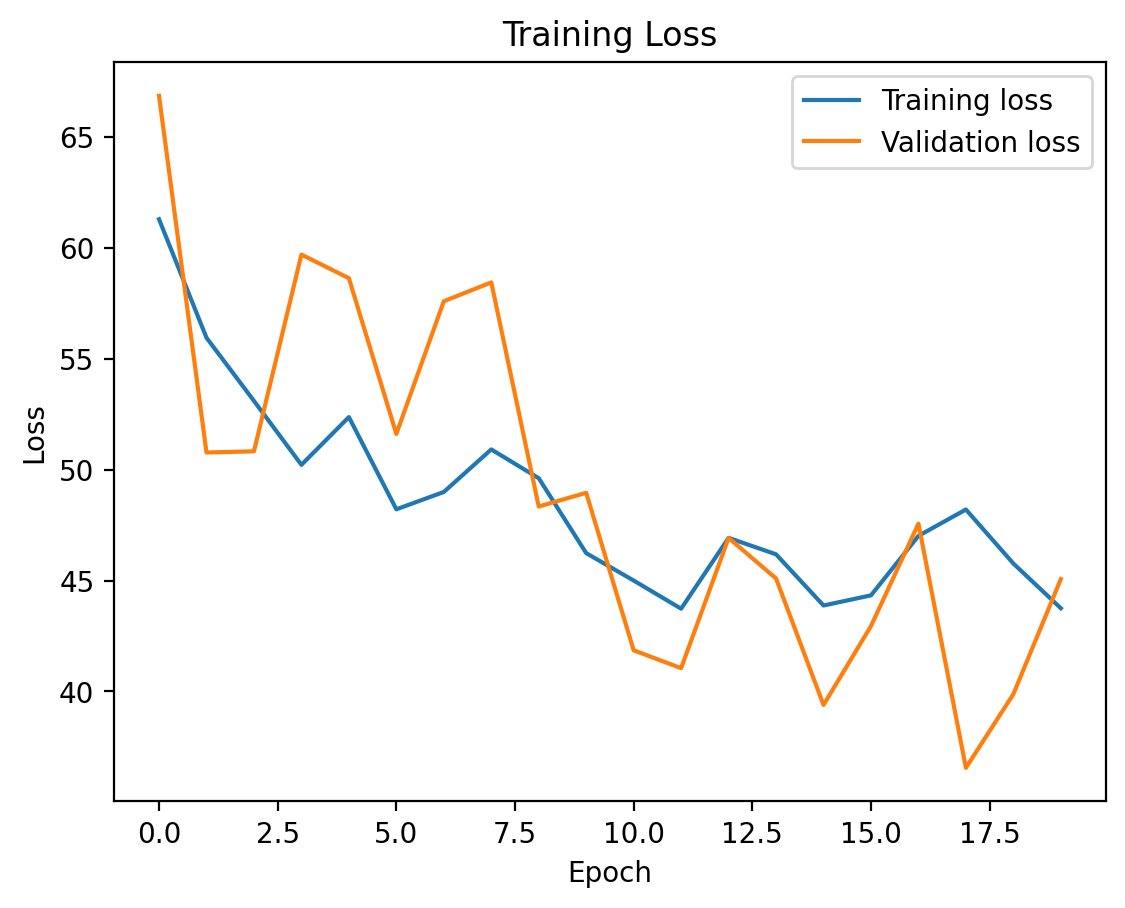

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_many_to_many_gru(many_to_many_gru, optimizer, criterion, num_epochs=20, train_loss_history=[], val_loss_history=[], create_plot=True)

It doesn't look good, but it still looks like it's falling down. Let's inspect the results after another 20 epochs:

<ipython-input-12-9499673c2641>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Training Loss: 45.224074209890055


Average Validation Loss: 44.21240081787109


Epoch 1:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Training Loss: 41.0631312401064


Average Validation Loss: 32.39410610198975


Epoch 2:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Training Loss: 46.06691680415984


Average Validation Loss: 43.35334510803223


Epoch 3:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


Average Training Loss: 43.41106396336709
Average Validation Loss: 41.57037620544433


Epoch 4:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]


Average Training Loss: 41.7422392137589
Average Validation Loss: 38.59916725158691


Epoch 5:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Training Loss: 42.29677495648784


Average Validation Loss: 40.97456855773926


Epoch 6:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Training Loss: 39.11496319309358


Average Validation Loss: 45.99049758911133


Epoch 7:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Training Loss: 39.463444679014145


Average Validation Loss: 39.18855094909668


Epoch 8:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Training Loss: 41.903158495503085


Average Validation Loss: 38.37220764160156


Epoch 9:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Training Loss: 41.839738599715695


Average Validation Loss: 45.53683204650879


Epoch 10:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Training Loss: 42.032315408029866


Average Validation Loss: 39.324117279052736


Epoch 11:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Training Loss: 41.1557669485769


Average Validation Loss: 41.57070426940918


Epoch 12:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Training Loss: 41.549102598621


Average Validation Loss: 38.57683906555176


Epoch 13:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Training Loss: 40.25210811245826


Average Validation Loss: 37.17735481262207


Epoch 14:: 100%|██████████| 31/31 [00:51<00:00,  1.66s/it]

Average Training Loss: 42.16294264024304


Average Validation Loss: 35.394422912597655


Epoch 15:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Training Loss: 40.26556101152974


Average Validation Loss: 45.51612014770508


Epoch 16:: 100%|██████████| 31/31 [00:56<00:00,  1.84s/it]

Average Training Loss: 40.80493748572565


Average Validation Loss: 43.42588081359863


Epoch 17:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Training Loss: 40.47550281401603


Average Validation Loss: 39.55179443359375


Epoch 18:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Training Loss: 40.44632597892515


Average Validation Loss: 32.793447494506836


Epoch 19:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Training Loss: 41.07642342967372


Average Validation Loss: 39.98923187255859


Epoch 20:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 40.019394351590066


Average Validation Loss: 38.199073028564456


Epoch 21:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Training Loss: 40.055487971152026


Average Validation Loss: 37.370414352416994


Epoch 22:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


Average Training Loss: 39.16585494625953
Average Validation Loss: 42.965895080566405


Epoch 23:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Training Loss: 40.361363011021766


Average Validation Loss: 37.23687057495117


Epoch 24:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Training Loss: 39.10472882178522


Average Validation Loss: 37.76956367492676


Epoch 25:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Training Loss: 38.20874398754489


Average Validation Loss: 40.28520393371582


Epoch 26:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Training Loss: 44.756043341852006


Average Validation Loss: 40.65747756958008


Epoch 27:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Training Loss: 38.77673189870773


Average Validation Loss: 38.81669807434082


Epoch 28:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


Average Training Loss: 44.43832139045961
Average Validation Loss: 35.6608341217041


Epoch 29:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 43.32541379620952


Average Validation Loss: 39.17743911743164


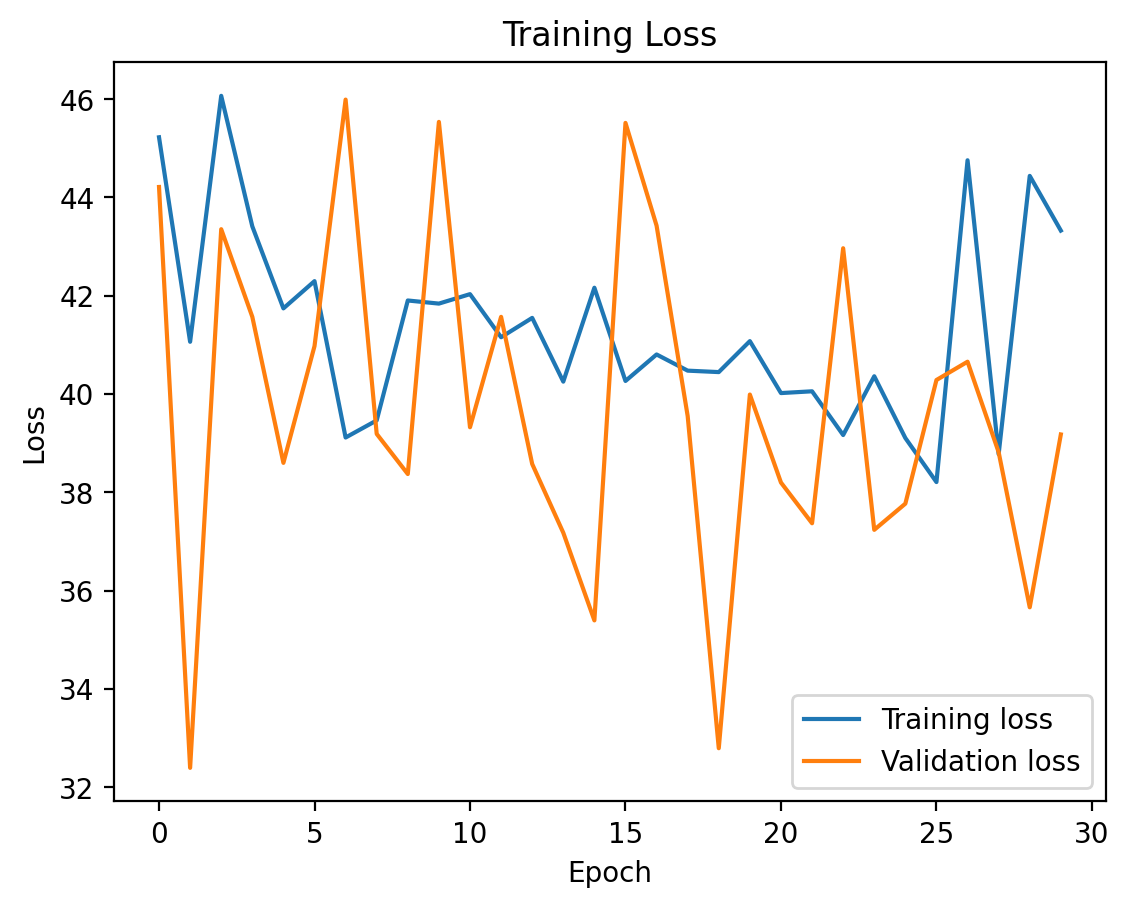

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_many_to_many_gru(many_to_many_gru, optimizer, criterion, num_epochs=30, train_loss_history=[], val_loss_history=[], create_plot=True)

The loss isn't improving, which indicates, that this architecture isn't suited for our task.